### Exploratory Data Analysis

In [118]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
data = pd.read_parquet("bank_data.parquet")

In [119]:
data.head(5)

,ZIBZIN,IDAvisAutorisationCheque,FlagImpaye,Montant,DateTransaction,CodeDecision,VerifianceCPT1,VerifianceCPT2,VerifianceCPT3,D2CB,...,TauxImpNb_RB,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr1,DiffDateTr2,DiffDateTr3,CA3TRetMtt,CA3TR,Heure
0,A013010004908126703060931,78643044,0,20.00,2017-02-01 07:32:14,1,0,0,0,551,...,37.186668,52.076034,0,1,4.000000,4.0,4.0,20.00,0.00,27134
1,A013011306908024927155000,78643045,0,20.00,2017-02-01 07:43:37,1,0,0,0,551,...,48.844716,52.076034,1,2,1.797685,4.0,4.0,28.61,8.61,27817
2,A013010002908283134592527,78643046,0,57.64,2017-02-01 07:47:38,1,0,0,0,549,...,73.118280,52.076034,0,1,4.000000,4.0,4.0,57.64,0.00,28058
3,A011010002908105209831316,78643047,0,54.29,2017-02-01 07:48:48,0,1,1,1,267,...,110.056926,53.554234,0,1,4.000000,4.0,4.0,54.29,0.00,28128
4,A013010041908000125652029,78643048,0,26.90,2017-02-01 08:13:27,1,0,0,0,549,...,45.368313,52.076034,1,1,1.997106,4.0,4.0,59.15,32.25,29607


In [120]:
data.shape

(4646773, 23)

Train/Test Split Based on Date

In [121]:
import duckdb as ddb

# Split dataset according to the given period (Feb 2017 - Nov 2017)
train_df = ddb.query("SELECT * FROM data WHERE DateTransaction <= '2017-08-31'").df()
test_df = ddb.query("SELECT * FROM data WHERE DateTransaction >= '2017-09-01'").df()




C:\Users\MSI\AppData\Local\Temp\ipykernel_25096\2405104598.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="FlagImpaye", data=train_df, palette="Set2")


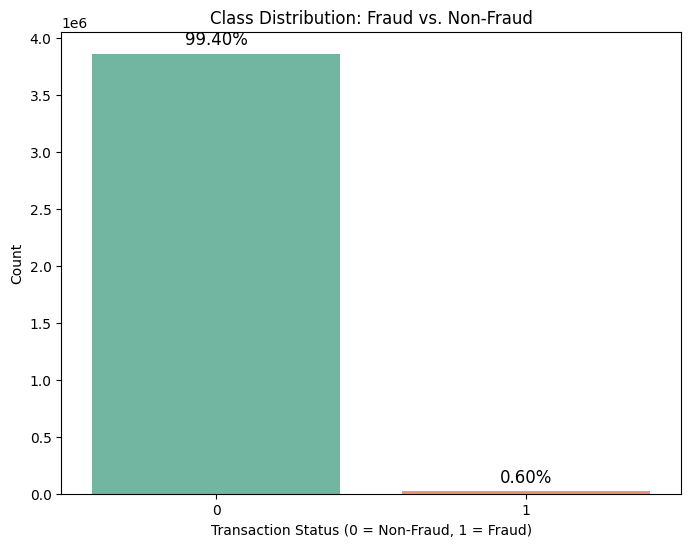

In [122]:
# Plotting the class distribution
plt.figure(figsize=(8, 6))
ax = sns.countplot(x="FlagImpaye", data=train_df, palette="Set2")

# Adding percentage labels on top of the bars
total = len(train_df)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.2f}%'
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 10), 
                textcoords='offset points')

plt.title("Class Distribution: Fraud vs. Non-Fraud")
plt.xlabel("Transaction Status (0 = Non-Fraud, 1 = Fraud)")
plt.ylabel("Count")
plt.show()


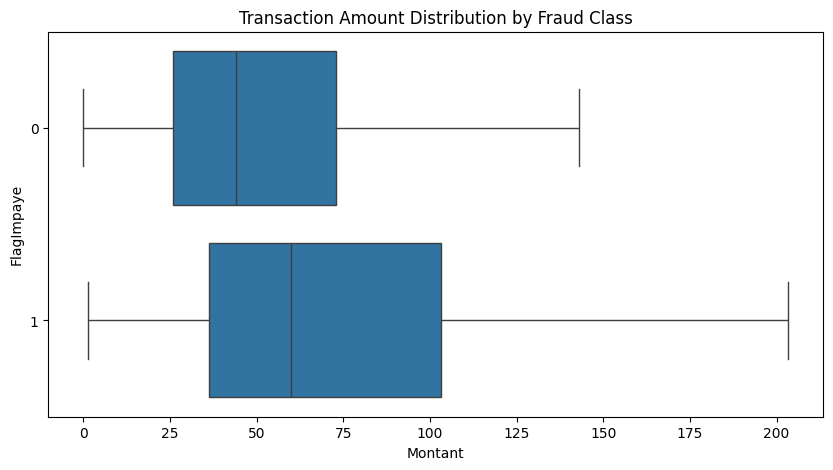

In [123]:
# Boxplot to visualize transaction amount distribution by fraud class
plt.figure(figsize=(10,5))
sns.boxplot(train_df, x="Montant", y="FlagImpaye", showfliers=False)
plt.title("Transaction Amount Distribution by Fraud Class")
plt.show()


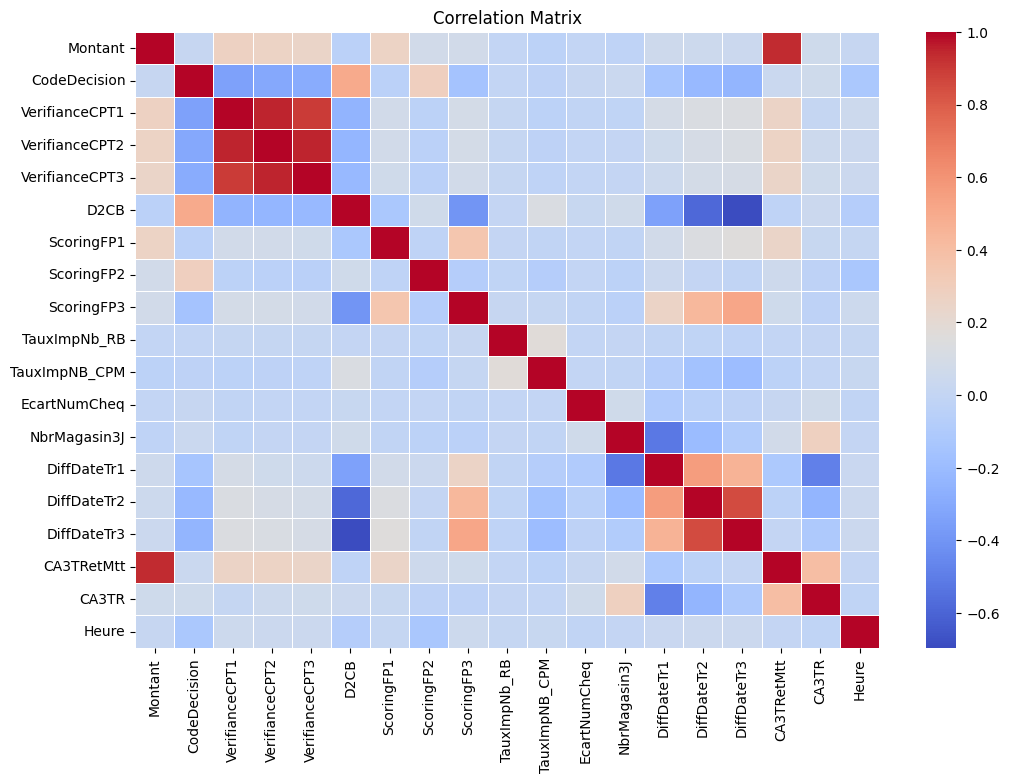

In [124]:

# Select only numeric columns
numeric_data = train_df.select_dtypes(include=["number"])

# Compute the correlation matrix
corr_matrix = numeric_data.corr()

# Plot the heatmap
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False, fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()



Feature-Specific Correlation Analysis

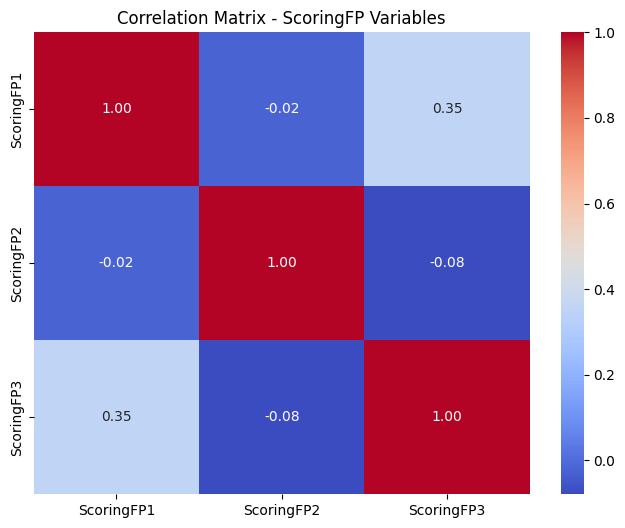

In [125]:
# Analyze correlation for ScoringFP variables
correlation_matrix = train_df[["ScoringFP1", "ScoringFP2", "ScoringFP3"]].corr()
plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix - ScoringFP Variables")
plt.show()


None of these variables exhibit strong correlation, indicating that they are not redundant.

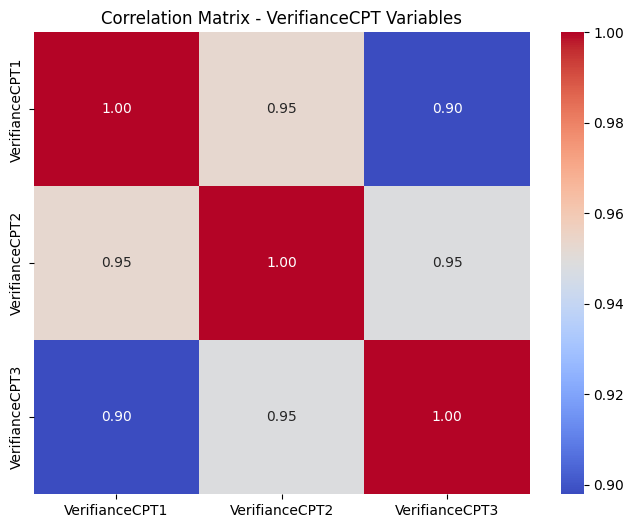

In [126]:
# Analyze correlation for VerifianceCPT variables
correlation_matrix = train_df[["VerifianceCPT1", "VerifianceCPT2", "VerifianceCPT3"]].corr()

plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix - VerifianceCPT Variables")
plt.show()


The three variables exhibit extremely strong correlations (> 0.9), making them redundant. Only VerifianceCPT2 is retained as it has the strongest correlation with the other two.

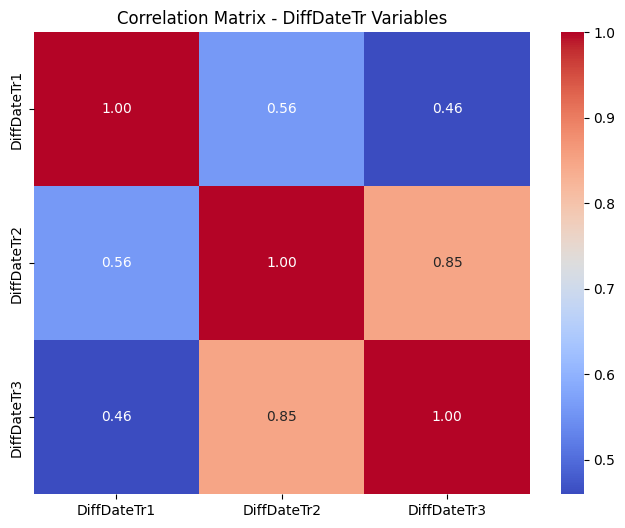

In [127]:
# Analyze correlation for DiffDateTr variables
correlation_matrix = train_df[["DiffDateTr1", "DiffDateTr2", "DiffDateTr3"]].corr()
plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix - DiffDateTr Variables")
plt.show()


The correlation values indicate a strong correlation between DiffDateTr2 and DiffDateTr3 (0.85), suggesting redundancy, while DiffDateTr1 shows moderate (0.56) and weaker (0.46) correlations with DiffDateTr2 and DiffDateTr3, respectively. As a result, we will create a synthetic variable that combines them (median of the gaps).

conclusion

VerifianceCPT1, VerifianceCPT2, and VerifianceCPT3 are highly correlated, indicating they capture similar information (recent transaction counts), so we retain only VerifianceCPT2; DiffDateTr1 is correlated with DiffDateTr2, which has an even stronger correlation with DiffDateTr3, and all show an inverse correlation with D2CB, suggesting the creation of a synthetic variable, while CodeDecision is removed as it is post-transaction information.

Feature Engineering & Selection

In [128]:
# Create a synthetic feature (MedianDiffDate)
train_df["MedianDiffDate"] = train_df[["DiffDateTr1", "DiffDateTr2", "DiffDateTr3"]].median(axis=1)

cols_to_drop = ["VerifianceCPT3", "VerifianceCPT1", "CodeDecision", "DiffDateTr1", "DiffDateTr2", "DiffDateTr3"]

train_df = train_df.drop(columns=cols_to_drop)


In [129]:
train_df.shape

(3888468, 18)

Create a Weekend Indicator

In [ ]:
# Create IsWeekend feature (1 if transaction occurred on a weekend)
train_df["DateTransaction"] = pd.to_datetime(train_df["DateTransaction"])


train_df["IsWeekend"] = train_df["DateTransaction"].dt.weekday.isin([5, 6]).astype(int)

train_df= train_df.drop(columns=['DateTransaction'])


In [131]:
train_df["IsWeekend"].value_counts() 

IsWeekend
0    2957444
1     931024
Name: count, dtype: int64

Statistical Tests for Feature Selection

1.Mann-Whitney U Test



In [132]:
from scipy.stats import mannwhitneyu

# Separate fraudulent and non-fraudulent transactions
fraud = train_df[train_df["FlagImpaye"] == "1"]
non_fraud = train_df[train_df["FlagImpaye"] == "0"]

# Select numeric columns
numeric_columns = train_df.select_dtypes(include=["number"]).columns

# Apply Mann-Whitney U Test
mw_results = {col: mannwhitneyu(fraud[col].dropna(), non_fraud[col].dropna(), alternative='two-sided')
              for col in numeric_columns}

# Convertir les résultats en DataFrame
mw_df = pd.DataFrame({col: [t.statistic, t.pvalue] for col, t in mw_results.items()}, index=["U-Statistic", "P-Value"]).T



In [133]:
mw_df

,U-Statistic,P-Value
Montant,5.568831e+10,0.000000e+00
VerifianceCPT2,5.600613e+10,0.000000e+00
D2CB,3.180685e+10,0.000000e+00
ScoringFP1,5.278204e+10,0.000000e+00
ScoringFP2,2.887909e+10,0.000000e+00
ScoringFP3,5.537660e+10,0.000000e+00
TauxImpNb_RB,5.897361e+10,0.000000e+00
TauxImpNB_CPM,5.476484e+10,0.000000e+00
EcartNumCheq,4.896996e+10,0.000000e+00
NbrMagasin3J,4.651200e+10,1.740854e-137


At first glance, all variables should be retained.

Kolmogorov-Smirnov (KS) Test

In [134]:
from scipy.stats import ks_2samp

# Apply Kolmogorov-Smirnov Test
ks_results = {col: ks_2samp(fraud[col].dropna(), non_fraud[col].dropna())
              for col in numeric_columns}

# Convertir les résultats en DataFrame
ks_df = pd.DataFrame({col: [t.statistic, t.pvalue] for col, t in ks_results.items()}, index=["KS-Statistic", "P-Value"]).T

# Afficher les résultats
print(ks_df)


                KS-Statistic        P-Value
Montant             0.171908   0.000000e+00
VerifianceCPT2      0.221034   0.000000e+00
D2CB                0.255751   0.000000e+00
ScoringFP1          0.195583   0.000000e+00
ScoringFP2          0.278918   0.000000e+00
ScoringFP3          0.230456   0.000000e+00
TauxImpNb_RB        0.213991   0.000000e+00
TauxImpNB_CPM       0.147378   0.000000e+00
EcartNumCheq        0.080242  2.047116e-130
NbrMagasin3J        0.030698   1.967737e-19
CA3TRetMtt          0.195608   0.000000e+00
CA3TR               0.087859  2.618944e-156
Heure               0.096152  3.468141e-187
MedianDiffDate      0.073121  2.412937e-108
IsWeekend           0.010222   1.555086e-02


Feature Importance Analysis (Random Forest)

In [135]:
from sklearn.ensemble import RandomForestClassifier

# Prepare dataset
X = train_df.drop(columns=["FlagImpaye", "IDAvisAutorisationCheque", "ZIBZIN"]) 
y = train_df["FlagImpaye"]


# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Get feature importance
feature_importance = pd.DataFrame({"Feature": X.columns, "Importance": rf.feature_importances_})
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)




C:\Users\MSI\AppData\Local\Temp\ipykernel_25096\4209931240.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance["Importance"], y=feature_importance["Feature"], palette="viridis")


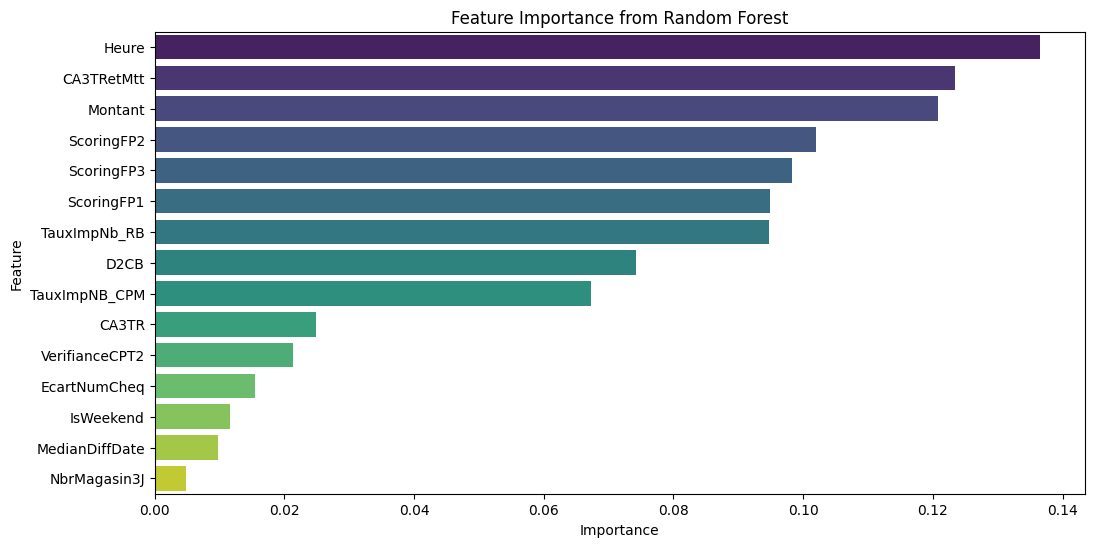

In [136]:
# Plot feature importance
plt.figure(figsize=(12,6))
sns.barplot(x=feature_importance["Importance"], y=feature_importance["Feature"], palette="viridis")
plt.title("Feature Importance from Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

Information Gain Analysis

In [137]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd

# Compute Information Gain
ig_values = mutual_info_classif(X, y, discrete_features=False)

# Create DataFrame
ig_df = pd.DataFrame({"Variable": X.columns, "Information Gain": ig_values})
ig_df = ig_df.sort_values(by="Information Gain", ascending=False)

print(ig_df)


          Variable  Information Gain
13  MedianDiffDate          0.271729
9     NbrMagasin3J          0.138187
14       IsWeekend          0.064559
1   VerifianceCPT2          0.063473
7    TauxImpNB_CPM          0.028432
2             D2CB          0.012300
6     TauxImpNb_RB          0.005676
5       ScoringFP3          0.004933
4       ScoringFP2          0.004731
3       ScoringFP1          0.003947
10      CA3TRetMtt          0.002624
0          Montant          0.002481
12           Heure          0.001804
11           CA3TR          0.000921
8     EcartNumCheq          0.000446


Final Feature Selection

Based on the conducted analyses, we decided to remove the variables NbrMagasin3J, EcartNumCheq, CA3TR, IsWeekend, and MedianDiffDate, with some uncertainty regarding MedianDiffDate and VerifianceCPT2, which will be tested both with and without them.

In [138]:
# Based on previous analysis, we remove low-importance features
cols_to_remove = ["ZIBZIN", "IDAvisAutorisationCheque","NbrMagasin3J", "EcartNumCheq", "CA3TR", "IsWeekend", "MedianDiffDate"]
train_df = train_df.drop(columns=cols_to_remove)


In [ ]:
# Keep only the same columns in the test set
remaining_columns = train_df.columns
test_df = test_df[remaining_columns]

In [139]:
print("\n🔹 Final train dataset shape after feature selection: ", train_df.shape)



🔹 Final train dataset shape after feature selection:  (3888468, 11)


In [ ]:
print("\n🔹 Final test dataset shape after feature selection: ", test_df.shape)


In [140]:
train_df.columns

Index(['FlagImpaye', 'Montant', 'VerifianceCPT2', 'D2CB', 'ScoringFP1',
       'ScoringFP2', 'ScoringFP3', 'TauxImpNb_RB', 'TauxImpNB_CPM',
       'CA3TRetMtt', 'Heure'],
      dtype='object')

In [ ]:
test_df.columns

Exporting the Preprocessed Data to Parquet Format


In [141]:
# Exporting Preprocessed Train and Test Data
train_file = "preprocessed_train_data.parquet"
test_file = "preprocessed_test_data.parquet"

train_df.to_parquet(train_file, index=False)
test_df.to_parquet(test_file, index=False)

print(f"✅ Preprocessed train data saved as {train_file}")
print(f"✅ Preprocessed test data saved as {test_file}")

✅ Preprocessed train data saved as preprocessed_train_data.parquet
✅ Preprocessed test data saved as preprocessed_test_data.parquet
